In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir /'13cyc'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
# Get Co-expression data
PPI_save_path =  data_dir / '13cyc' / 'PPI' / 'expression'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path, index_col=0)
        dfs.append(df)

df_exp = pd.concat(dfs)

In [6]:
# Check for general trend y converting to adata and groupby by Condition
df_obs = df_exp.iloc[:, :9]
df_marker_exp = df_exp.iloc[:, 9:]
df_norm = (df_marker_exp-df_marker_exp.min())/(df_marker_exp.max()-df_marker_exp.min())
# df_norm = (df_marker_exp - df_marker_exp.mean())/df_marker_exp.std()
# df_norm = (df_marker_exp-df_marker_exp.quantile(0.05))/(df_marker_exp.quantile(0.95)-df_marker_exp.quantile(0.05))
df_norm = df_norm.clip(lower=0, upper=1)
df_exp.iloc[:, 9:] = df_norm

# Plot images

In [5]:
for row in df_imgs.itertuples():
    path = row.Path
    # Read markers name 
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
        imgs= f['imgs'][:]
    break

In [7]:
import napari

viewer = napari.view_image(imgs, channel_axis=0, name=markers, visible=False)

In [8]:
# Read PPI 
PPI_save_path =  data_dir / '13cyc'  / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)
df = df.rename(columns={'x': 'row', 'y': 'column'})
df.head()

,Cyto,row,column,PPI,Nuclei,Nuclei_Cell,Condition,FOV
0,0,2736,7959,Sox2/Oct4,0,0,100nM,FW1
1,0,3372,1682,Sox2/Oct4,0,0,100nM,FW1
2,0,19,7286,Sox2/Oct4,0,0,100nM,FW1
3,0,3204,7861,Sox2/Oct4,0,0,100nM,FW1
4,928,3281,1355,Sox2/Oct4,0,0,100nM,FW1


In [14]:
PPIs = df.PPI.unique()
Condition = row.Condition
FOV = row.FOV 
points_all = []
for ppi in PPIs:
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == ppi]
    points = df_ppi[['row', 'column']].to_numpy()
    points_all.append(points)

In [16]:
import napari

viewer = napari.view_image(imgs, channel_axis=0, name=markers, visible=False)
for j, point in enumerate(points_all):
    points_layer = viewer.add_points(point, size=5, name=PPIs[j], visible=False)

# IF histogram plot

In [7]:
import anndata as ad
import scanpy as sc
sc.set_figure_params(transparent=True)

adata = ad.AnnData(df_marker_exp.values, dtype=df_norm.values.dtype)
adata.var_names = df_marker_exp.columns.tolist()
adata.obs = df_obs
adata.obs['PPI'] = adata.obs['PPI'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=4)
sc.tl.dendrogram(adata, groupby='PPI')

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [8]:
df = pd.DataFrame(adata.X, columns=adata.var_names.tolist())
df['PPI'] = adata.obs['PPI'].tolist()
df['Condition'] = adata.obs['Condition'].tolist()

In [9]:
protein_markers = ['Hoechst', 'p-EGFR', 'Ki67', 'NBD-C6', 'COX IV', 'Pan-cytokeratin',
       'Concanavalin A', 'WGA']

protein_markers2 = ['p-EGFR', 'Ki67', 'NBD-C6', 'COX IV', 'Pan-cytokeratin']

In [10]:
df.head()

,Hoechst,Sox2/Oct4,NF-Kb/p-P90rsk,SIRT1/P53,TRAIL/DR5,Cyclin D1/CDK4,Bim/Tom20,EGFR/GRB2,FoxO1/AKT,p-ERK/c-MYC,...,p-EGFR,Phalloidin,Ki67,NBD-C6,COX IV,Pan-cytokeratin,Concanavalin A,WGA,PPI,Condition
0,-0.640658,4.0,-0.428195,-0.455326,-0.878405,-0.786745,-0.844502,-0.906209,-0.839088,0.002988,...,-1.090838,-1.057954,-0.659841,-0.763821,-0.996815,-0.446381,-0.862382,-1.016712,Sox2/Oct4,100nM
1,1.561809,4.0,0.986079,1.080159,0.646757,0.528670,0.901330,0.475431,0.968217,-0.117433,...,0.218387,1.043272,1.063641,0.174217,0.336808,0.913133,0.561908,0.036082,Sox2/Oct4,100nM
2,0.866045,4.0,-0.358934,0.303742,0.413034,0.099198,-0.105568,-0.398637,-0.435453,-0.169790,...,-0.079584,-0.378904,0.048728,-0.280786,-0.981626,-0.024463,-0.250724,-0.397367,Sox2/Oct4,100nM
3,1.429580,4.0,1.493252,1.482104,1.061735,0.393669,0.498570,0.212688,1.091119,-0.227382,...,0.190700,0.114572,0.799389,0.021112,-0.468226,-0.716257,-0.338103,-0.506880,Sox2/Oct4,100nM
4,0.143598,4.0,0.159410,0.819908,1.144015,0.411388,0.682086,0.269416,0.713357,1.730767,...,0.101045,0.246886,1.402725,-0.028486,1.339304,-0.277868,-0.030090,0.116146,Sox2/Oct4,100nM


In [ ]:
sns.set_style("white")

with sns.plotting_context("notebook", font_scale=2.2):
    fig, axs = plt.subplots(13, len(protein_markers2), figsize=(25,40), sharey=True, sharex=True)
    for i, PPI in enumerate(df.PPI.unique()):
        df_subset = df[df.PPI == PPI][['Condition'] + protein_markers2].reset_index(drop=True)
        # Plot kde
        for j, marker in enumerate(protein_markers2):
            g = sns.kdeplot(data=df_subset, x=marker, ax=axs[i, j], bw_adjust=0.5, lw=2)
            axs[i,j].get_legend().set_visible(False)
        axs[i,2].set_title(PPI)
    fig.subplots_adjust(wspace=0.02)

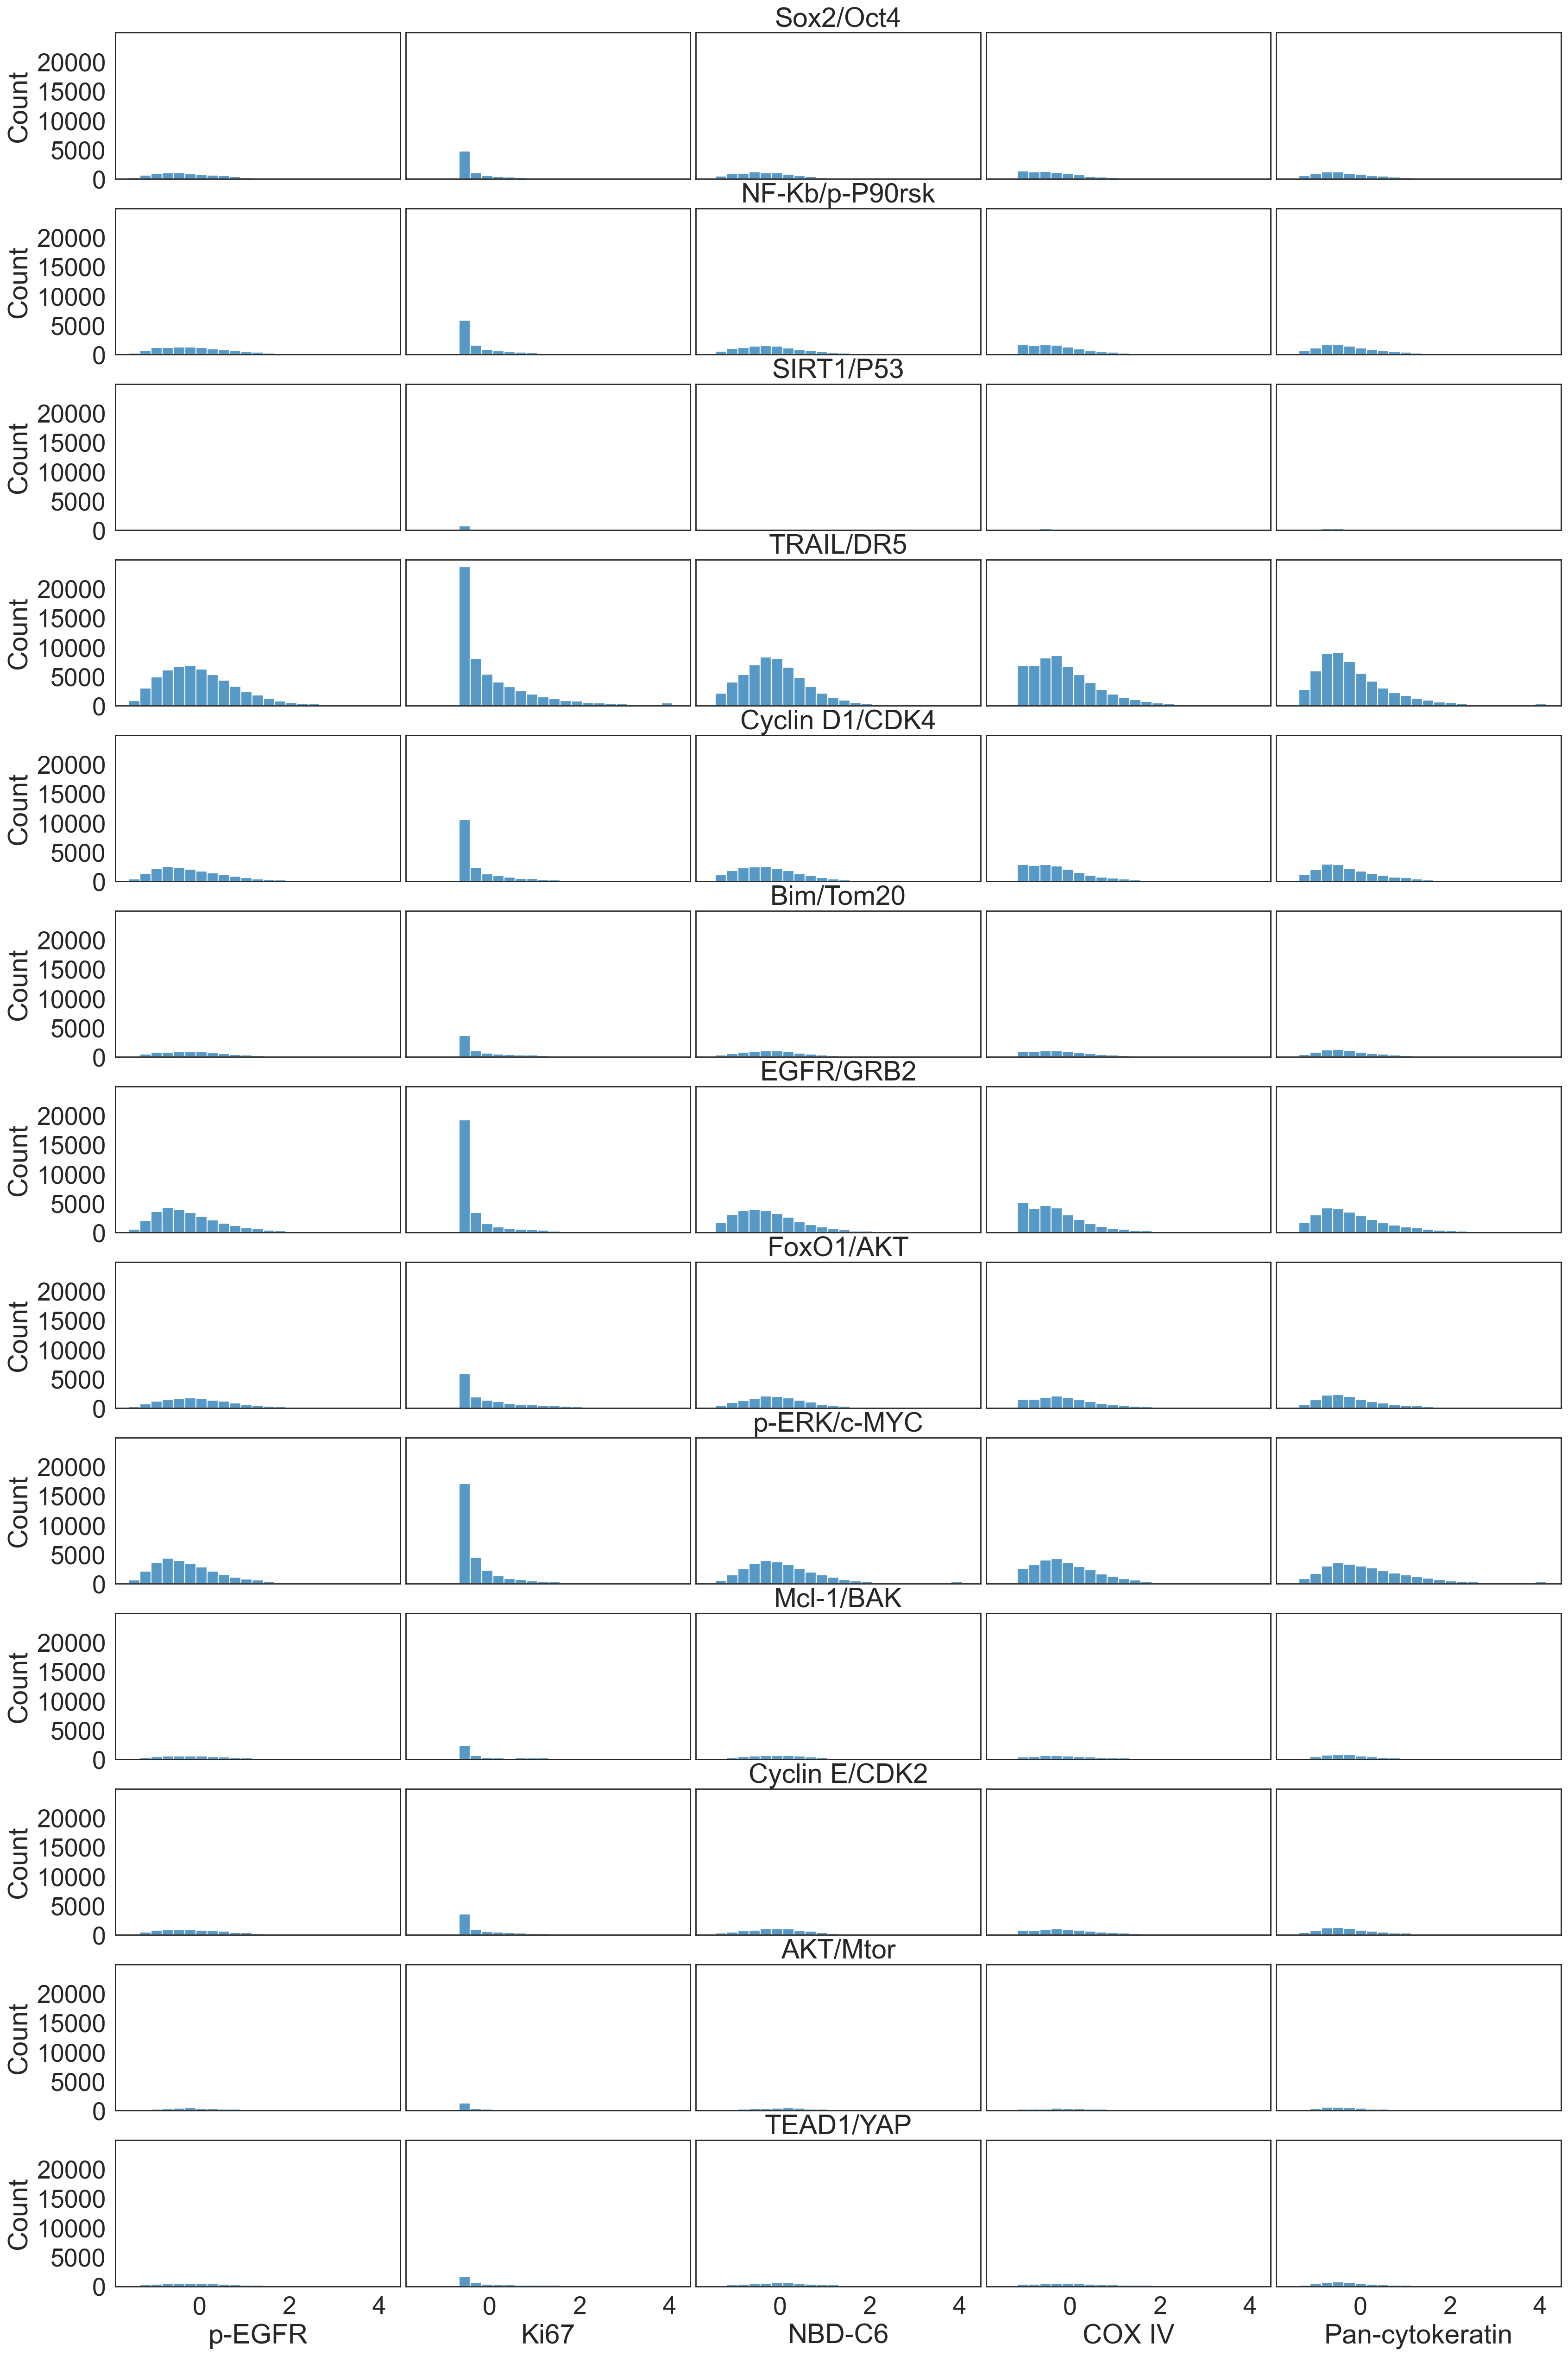

In [19]:
sns.set_style("white")

with sns.plotting_context("notebook", font_scale=2.2):
    fig, axs = plt.subplots(13, len(protein_markers2), figsize=(25,40), sharey=True, sharex=True)
    for i, PPI in enumerate(df.PPI.unique()):
        df_subset = df[df.PPI == PPI][['Condition'] + protein_markers2].reset_index(drop=True)
        # Plot kde
        for j, marker in enumerate(protein_markers2):
            g = sns.histplot(data=df_subset, x=marker, ax=axs[i, j],binwidth=0.25,)

        axs[i,2].set_title(PPI)
    fig.subplots_adjust(wspace=0.02)

# PPI co-expression box_plot

In [7]:
from statannotations.Annotator import Annotator

def plot(plotting, ):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(15,3))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.barplot(**plotting, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        
def plot(plotting, ax):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]


    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
    result = annot.apply_test().annotate()
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

## Co-expression plot

In [8]:
import anndata as ad
import scanpy as sc
sc.set_figure_params(transparent=True)
df_marker_exp = df_marker_exp.drop(['Phalloidin'], axis=1)

adata = ad.AnnData(df_marker_exp.values, dtype=df_norm.values.dtype)
adata.var_names = df_marker_exp.columns.tolist()
adata.obs = df_obs
adata.obs['PPI'] = adata.obs['PPI'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=1.5)
sc.tl.dendrogram(adata, groupby='PPI')

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [9]:
df = pd.DataFrame(adata.X, columns = adata.var_names)
df['PPI'] = adata.obs['PPI'].tolist()

df.groupby(['PPI']).mean().to_clipboard()

In [9]:
protein_markers = ['Hoechst', 'p-EGFR', 'Ki67', 'NBD-C6', 'COX IV', 'Pan-cytokeratin',
       'Concanavalin A', 'WGA']

protein_markers2 = ['p-EGFR', 'Ki67', 'NBD-C6', 'COX IV', 'Pan-cytokeratin',
       'Concanavalin A', 'WGA']

In [12]:
df = pd.DataFrame(adata.X, columns = adata.var_names)
df.describe().to_clipboard()

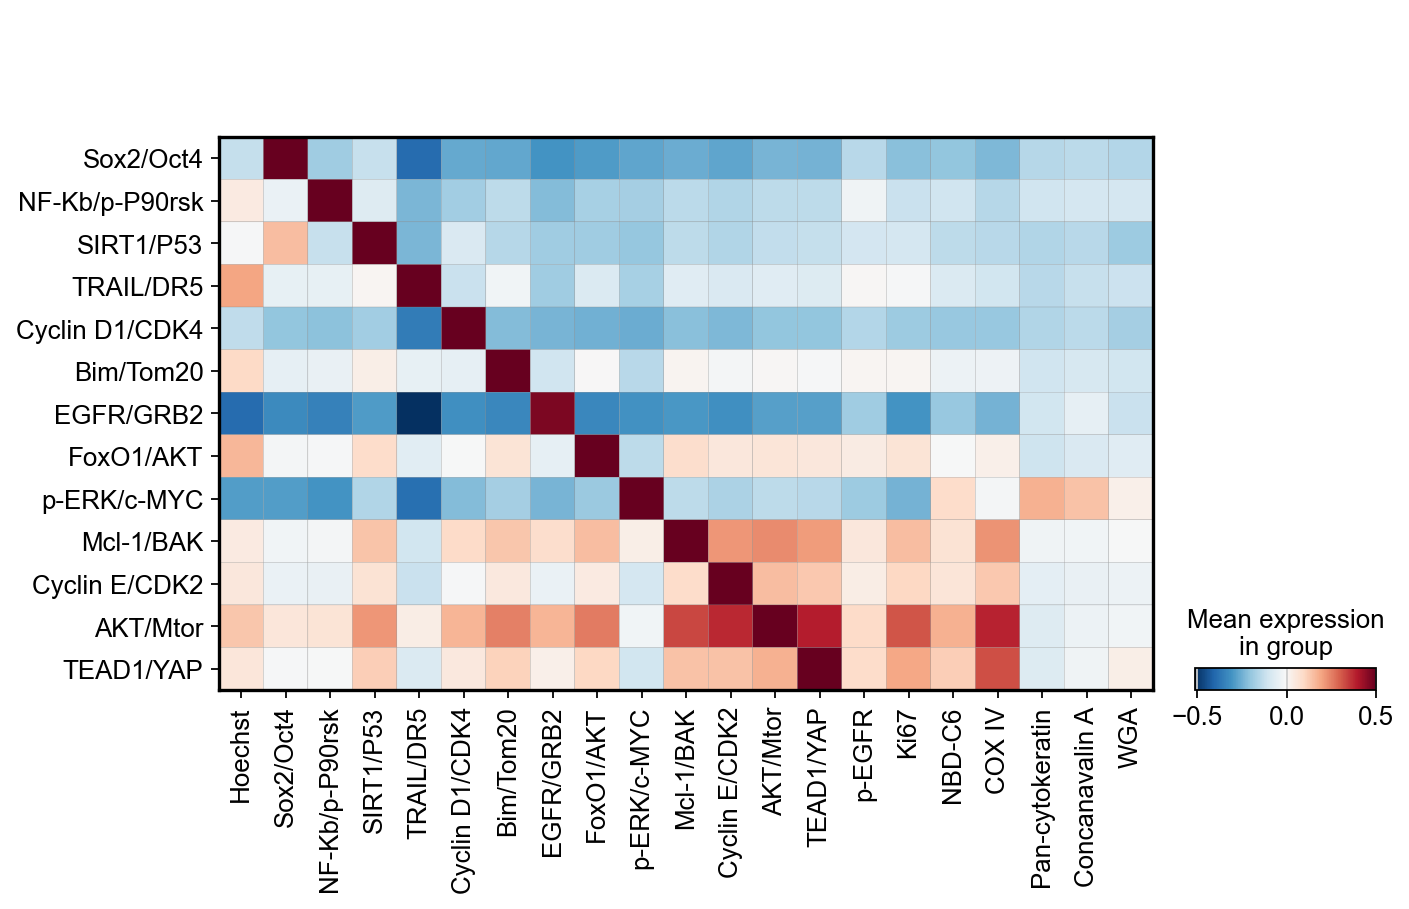

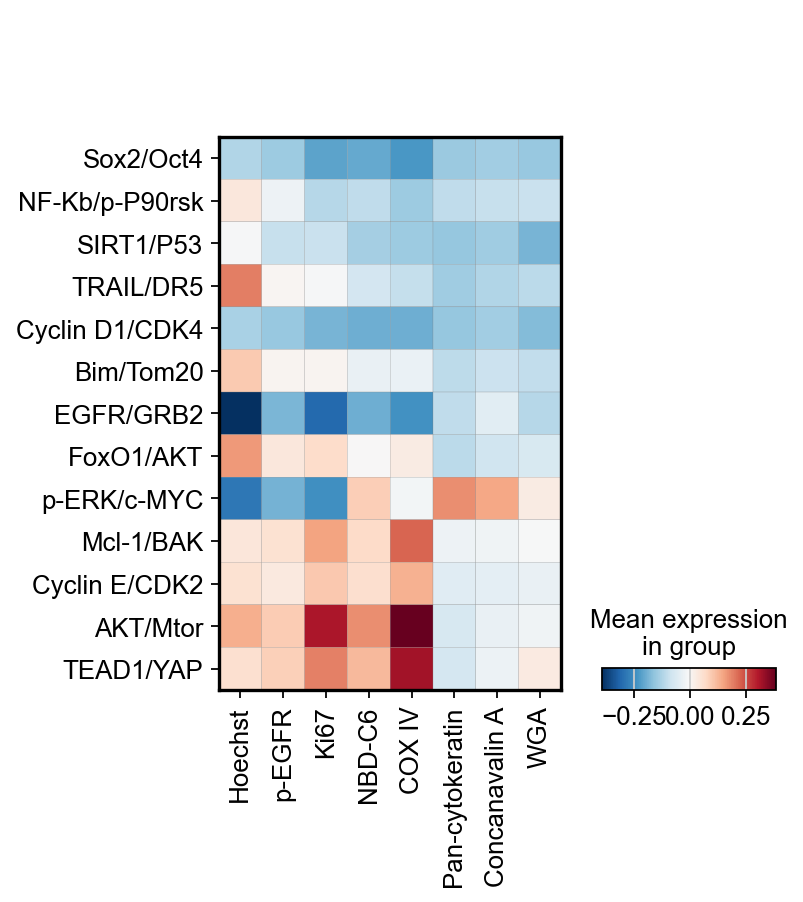

In [43]:
sc.pl.matrixplot(adata, adata.var_names, 'PPI', dendrogram=False, categories_order=adata.var_names[1:14], cmap='RdBu_r', vmax=0.5)
sc.pl.matrixplot(adata, protein_markers , 'PPI', dendrogram=False, categories_order=adata.var_names[1:14], cmap='RdBu_r')

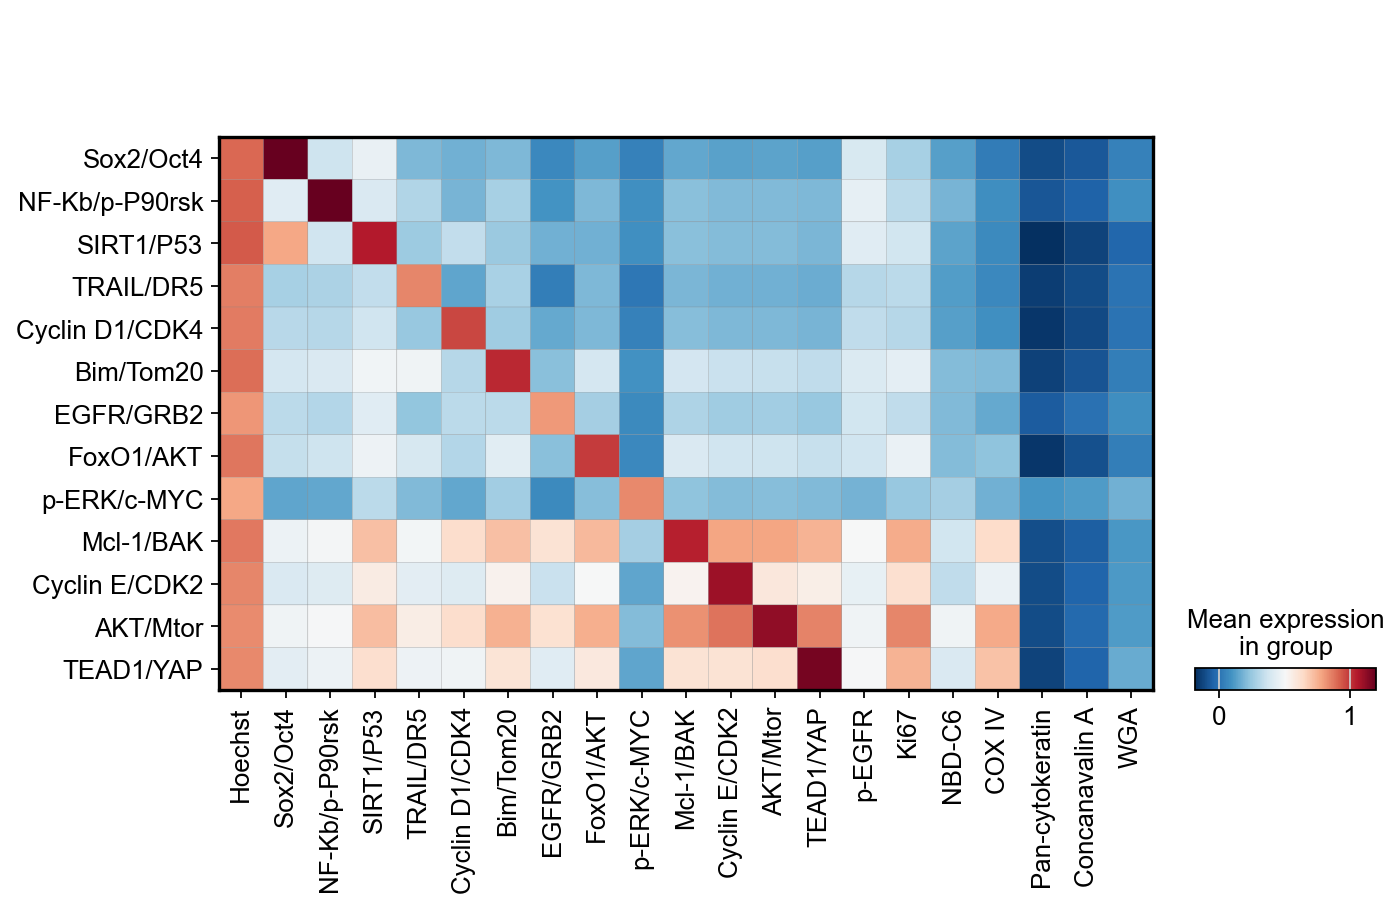

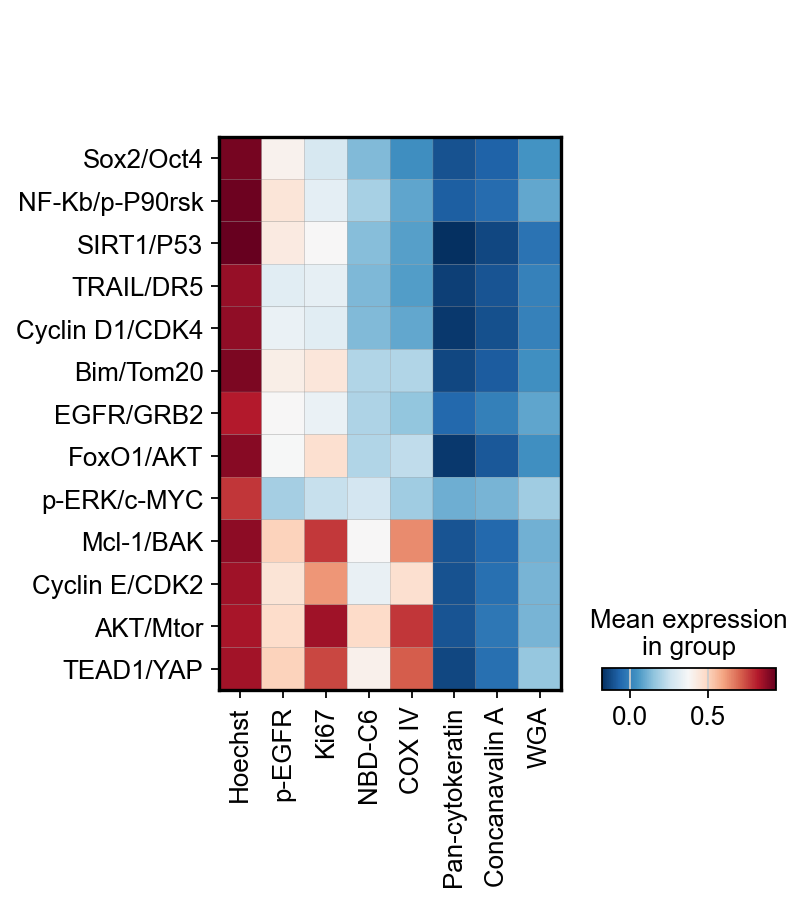

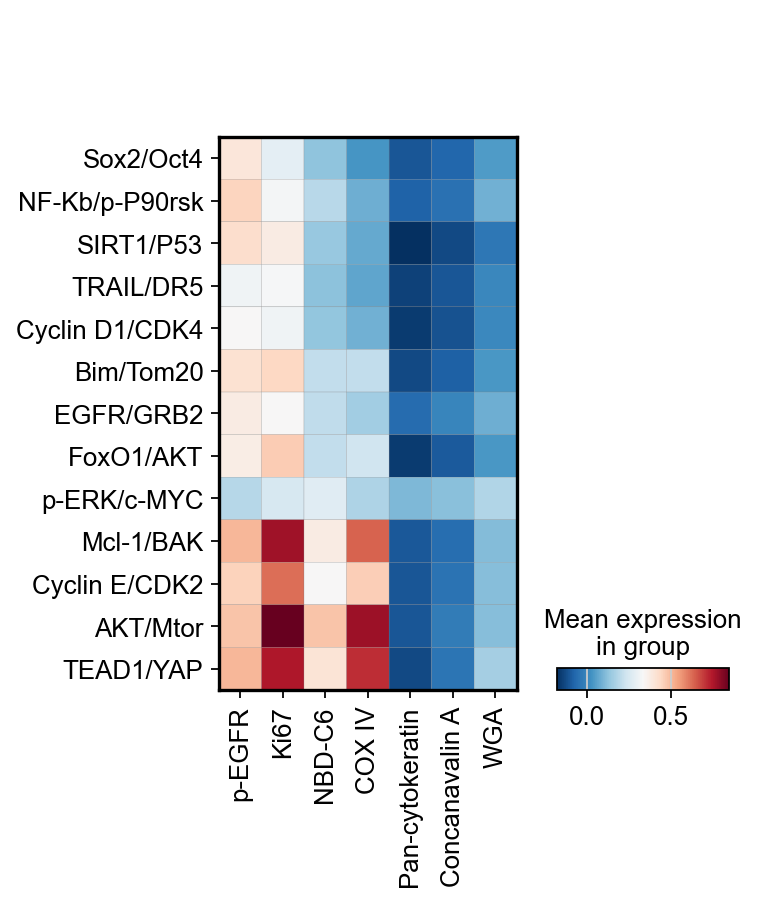

In [46]:
### Filter nuclei only
adata_subset = adata[adata.obs.Nuclei > 0]

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=False, categories_order=adata_subset.var_names[1:14], cmap='RdBu_r', vmax=1.2)
sc.pl.matrixplot(adata_subset, protein_markers , 'PPI', dendrogram=False, categories_order=adata_subset.var_names[1:14], cmap='RdBu_r')

sc.pl.matrixplot(adata_subset, protein_markers2, 'PPI', dendrogram=False, categories_order=adata_subset.var_names[1:14], cmap='RdBu_r')

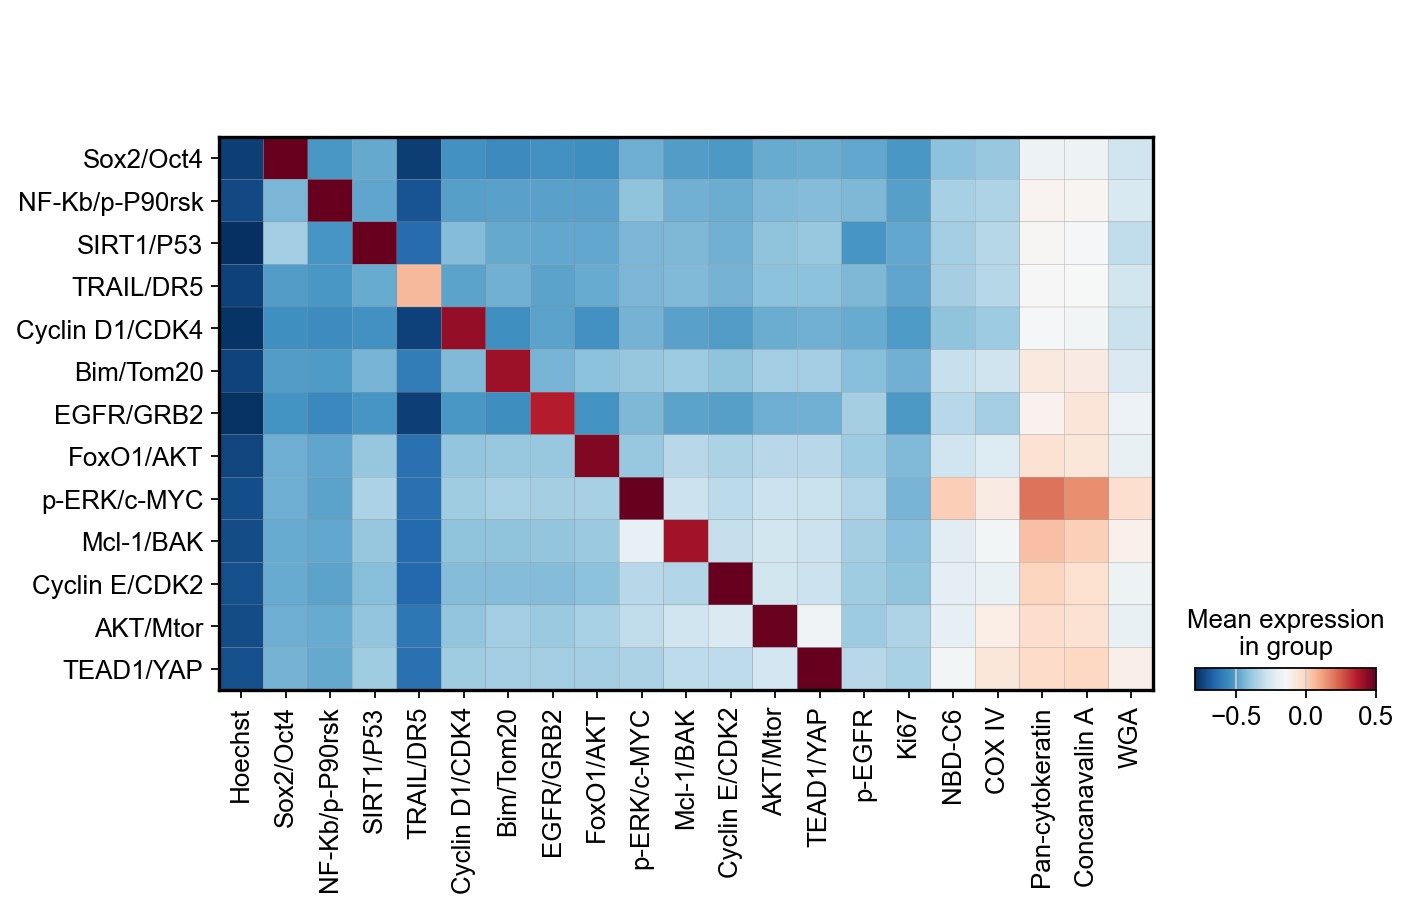

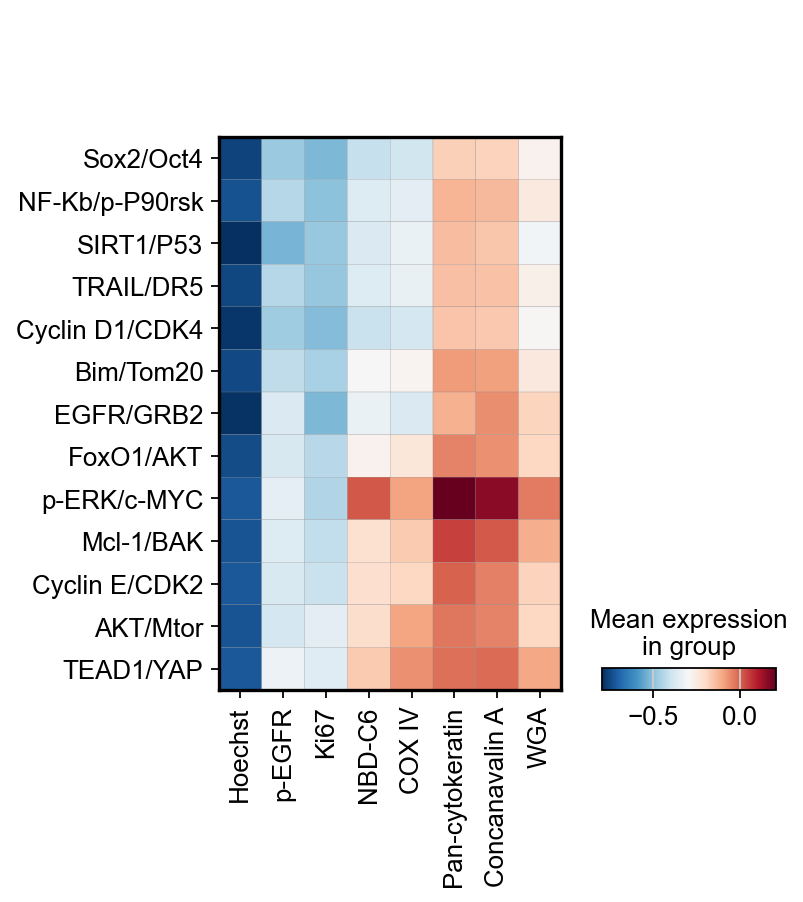

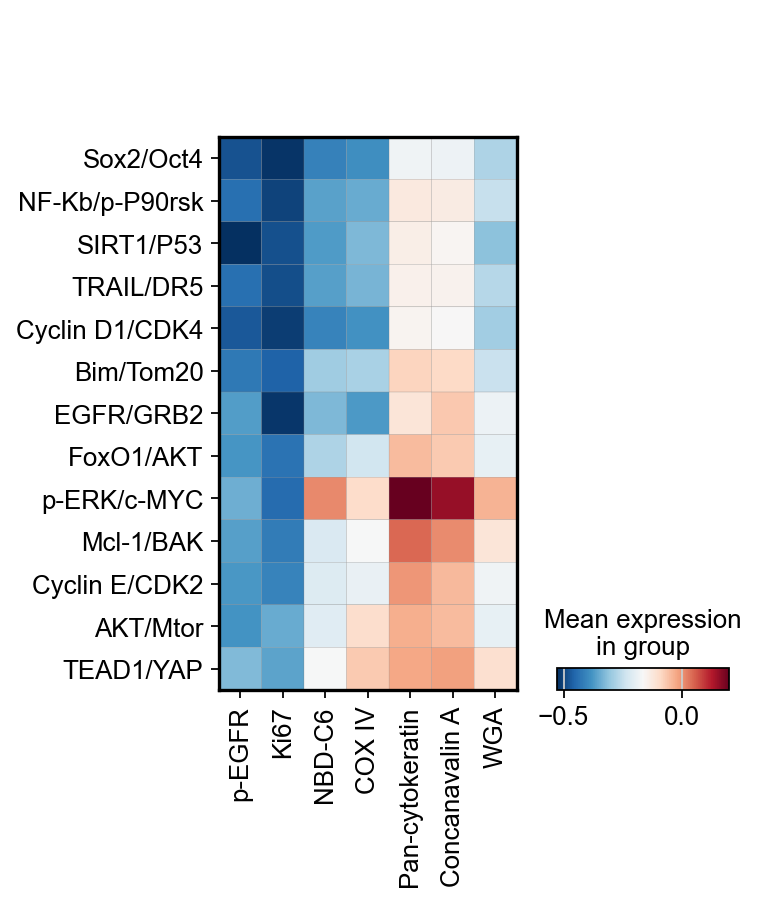

In [49]:
### Filter nuclei only
adata_subset = adata[adata.obs.Nuclei == 0]

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=False, categories_order=adata_subset.var_names[1:14], cmap='RdBu_r', vmax=0.5)
sc.pl.matrixplot(adata_subset, protein_markers , 'PPI', dendrogram=False, categories_order=adata_subset.var_names[1:14], cmap='RdBu_r')

sc.pl.matrixplot(adata_subset, protein_markers2, 'PPI', dendrogram=False, categories_order=adata_subset.var_names[1:14], cmap='RdBu_r')